## SARIMAX model


### Импортируем библиотеки

In [3]:
import warnings
warnings.filterwarnings("ignore")

import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(font_scale=1.3)

### Работа с данными

Загружаем данные по заказам

In [4]:
orders = pd.read_csv('datasets/orders.csv')
orders['date'] = pd.to_datetime(orders['date'])

Начало ряда

In [5]:
orders.head()

,delivery_area_id,date,orders_cnt
0,0,2021-04-01 10:00:00,9
1,0,2021-04-01 11:00:00,1
2,0,2021-04-01 13:00:00,1
3,0,2021-04-01 14:00:00,1
4,0,2021-04-01 15:00:00,2


Конец ряда

In [6]:
orders.tail()

,delivery_area_id,date,orders_cnt
884851,592,2021-11-30 16:00:00,6
884852,592,2021-11-30 17:00:00,3
884853,592,2021-11-30 18:00:00,2
884854,592,2021-11-30 19:00:00,4
884855,592,2021-11-30 20:00:00,4


Посмотрим на конкретный промежуток

In [7]:
orders.loc[18: 22]

,delivery_area_id,date,orders_cnt
18,0,2021-04-02 19:00:00,3
19,0,2021-04-02 20:00:00,2
20,0,2021-04-03 10:00:00,3
21,0,2021-04-03 11:00:00,1
22,0,2021-04-03 12:00:00,8


Заметим, что на этом промежутке отсутсвуют значения после 20:00:00 и до 10:00:00

Посчитаем кол-во уникальных областей доставки

In [8]:
orders['delivery_area_id'].nunique()

593

Посмотрим на пропущенные значения в данных

In [9]:
orders.isnull().sum()

delivery_area_id    0
date                0
orders_cnt          0
dtype: int64

### Данных много, поэтому попробуем для начала обработать сумму заказов по всем локациям

#### Обработка исходных данных

Для этого сгруппируем данные по дате и просумируем кол-во заказов в каждой группе с помощью функции `grouby` и `sum`

In [10]:
orders_sum_all_area = orders.groupby(['date'], as_index = True)['orders_cnt'].sum()
orders_sum_all_area.head()

date
2021-04-01 07:00:00      1
2021-04-01 08:00:00      2
2021-04-01 09:00:00      7
2021-04-01 10:00:00    200
2021-04-01 11:00:00    110
Name: orders_cnt, dtype: int64

Ежечасовые данные обрабатывать сложно, поэтому вместо этого попробуем использовать ежедневную сумму по кол-ву заказов.
Обработку сделаем с помощью функции `resample`. Пропуски в данных уберем при помощи функции `fillna` по предыдущим значениям (метод `ffill`).

In [11]:
orders_sum_all_area_day_sum = orders_sum_all_area.resample('D').sum()
orders_sum_all_area_day_sum = orders_sum_all_area_day_sum.fillna(method='ffill')
orders_sum_all_area_day_sum.head()

date
2021-04-01    1280
2021-04-02    1192
2021-04-03    1269
2021-04-04    1261
2021-04-05    1928
Freq: D, Name: orders_cnt, dtype: int64

Посмотрим на конец данных

In [12]:
orders_sum_all_area_day_sum.tail()

date
2021-11-26    34853
2021-11-27    40550
2021-11-28    40440
2021-11-29    33392
2021-11-30    36311
Freq: D, Name: orders_cnt, dtype: int64

Изобразим ряд на графике

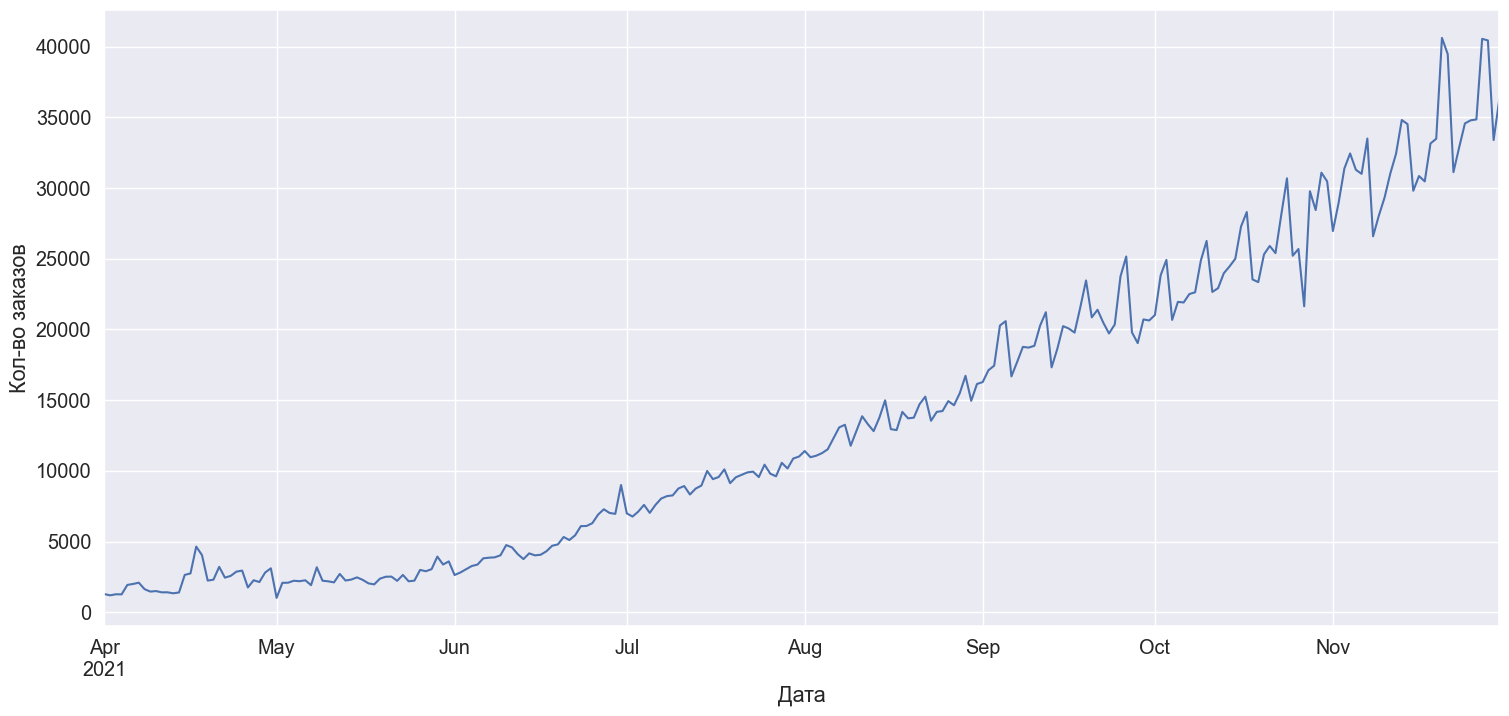

In [13]:
orders_sum_all_area_day_sum.plot(figsize=(18, 8))
plt.ylabel('Кол-во заказов')
plt.xlabel('Дата')
plt.show()

Выделим тренировочные и тестовые данные

In [14]:
train = orders_sum_all_area_day_sum[:-30]
test = orders_sum_all_area_day_sum[-30:]

Посмотрим на конец тренировочных и начало тестовых данных

In [15]:
train.tail()

date
2021-10-27    21637
2021-10-28    29772
2021-10-29    28443
2021-10-30    31086
2021-10-31    30470
Freq: D, Name: orders_cnt, dtype: int64

In [16]:
test.head()

date
2021-11-01    26961
2021-11-02    28965
2021-11-03    31381
2021-11-04    32447
2021-11-05    31293
Freq: D, Name: orders_cnt, dtype: int64

#### Анализ ряда

Графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF).

<a href="http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_acf.html">`statsmodels.graphics.tsaplots.plot_acf`</a>`(x, ax=None, lags=None, alpha=0.05, use_vlines=True, unbiased=False, fft=False, title='Autocorrelation', zero=True, **kwargs)`

<a href="http://www.statsmodels.org/dev/generated/statsmodels.graphics.tsaplots.plot_pacf.html">`statsmodels.graphics.tsaplots.plot_pacf`</a>`(x, ax=None, lags=None, alpha=0.05, method='ywm', use_vlines=True, title='Partial Autocorrelation', zero=True, **kwargs)`

* `x` &mdash; временной ряд;
* `lags` &mdash; набор лагов в виде списка или число &mdash; количество лагов (используется `np.arange(lags)`);
* `ax` &mdash; фигура `matplotlib`;
* `alpha` &mdash; уровень доверия для доверительных интервалов.

На графиках по горизонтальной оси изображены лаги. Синими точками отмечены значения функций, для наглядности рисуется также отрезок, соединяющий их с горизонтальной осью. Закрашенная область соответствует области незначимой корреляции. Все значения, лежащие вне закрашенной области признаются значимо отличными от нуля.

Не забываем также, что в нуле значение всегда равно 1 &mdash; корреляция случайной величины с самой собой.

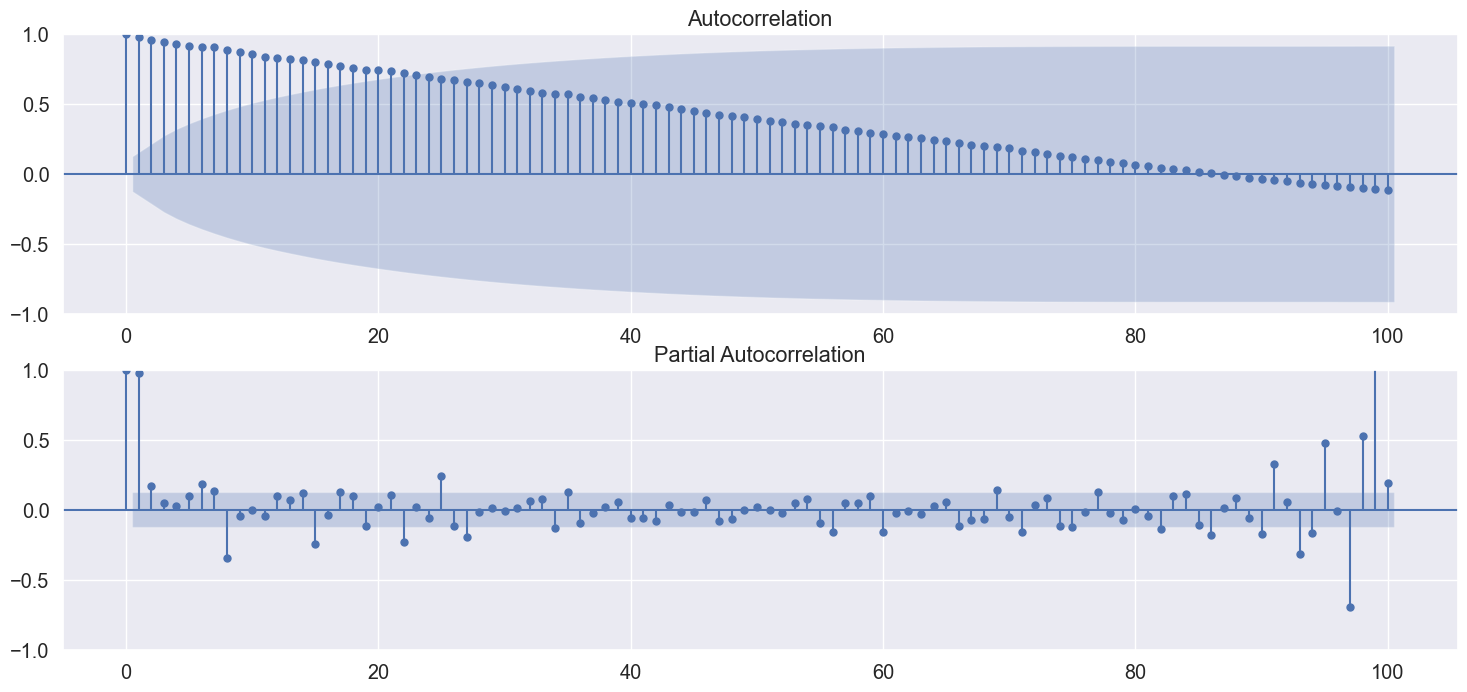

In [17]:
fig = plt.figure(figsize=(18, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(orders_sum_all_area_day_sum, lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(orders_sum_all_area_day_sum, lags=100, ax=ax2)
plt.show()

В данных явно есть линейный тренд, что видно по большим значеням автокорреляции.
Продифференцируем ряд, чтобы убрать тренд и изобразим график полученного ряда.

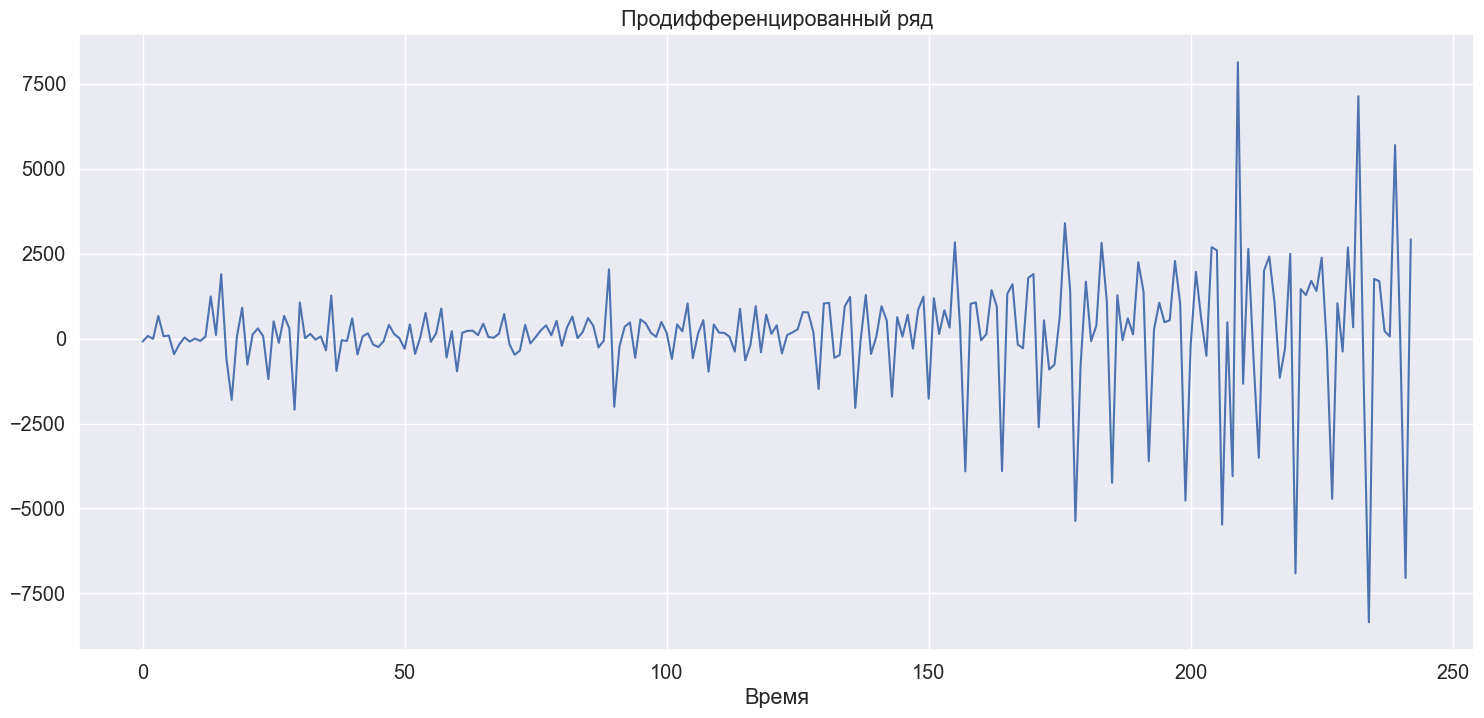

In [18]:
orders_sum_all_area_day_sum_arr = np.array(orders_sum_all_area_day_sum)
orders_sum_all_area_day_sum_dif = orders_sum_all_area_day_sum_arr[1:] - orders_sum_all_area_day_sum_arr[:-1]  # дифференцирование

plt.figure(figsize=(18, 8))
plt.plot(orders_sum_all_area_day_sum_dif)
plt.xlabel('Время')
plt.title('Продифференцированный ряд')
plt.show()

Теперь построим графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF) для продифференцированного ряда.

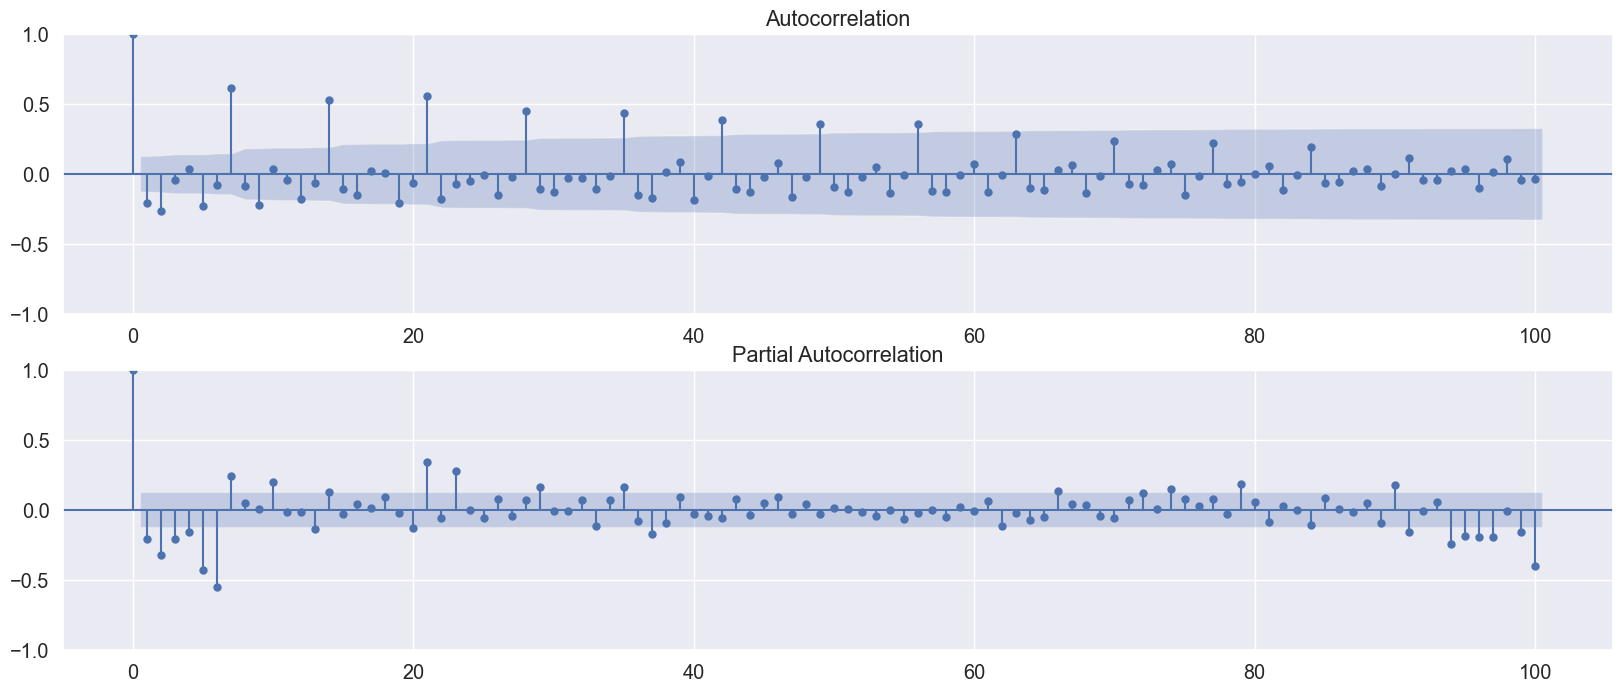

In [19]:
fig = plt.figure(figsize=(20, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(orders_sum_all_area_day_sum_dif, lags=100, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(orders_sum_all_area_day_sum_dif, lags=100, ax=ax2)
plt.ylim((-1, 1))
plt.show()

Как график продифференцированного ряда, так и его автокорреляционная функция намекают на сезонность. По графику автокорреляций, например, мы видим положительные пики при значениях лага, кратных 7. Максимальное значение автокорреляции имеет 7-й лаг.

Ряд с сезонностью не является стационарным, т.к. распределение ряда меняется в зависимости от сезона.

Применим дополнительно к нашему ряду еще сезонное дифференцирование.
Период сезонности известен заранее &mdash; 7 дней.

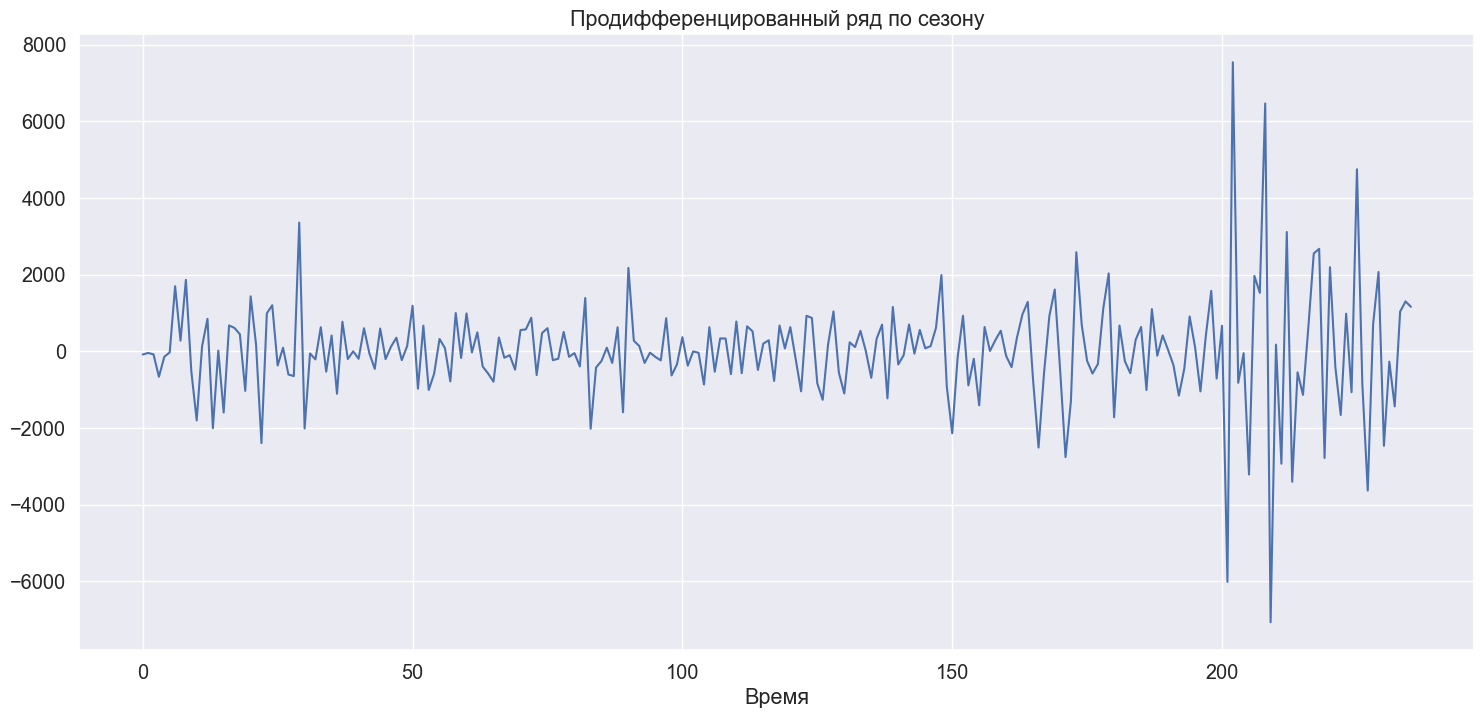

In [20]:
orders_sum_all_area_day_sum_sdif = orders_sum_all_area_day_sum_dif[7:] - orders_sum_all_area_day_sum_dif[:-7]

plt.figure(figsize=(18, 8))
plt.plot(orders_sum_all_area_day_sum_sdif)
plt.xlabel('Время')
plt.title('Продифференцированный ряд по сезону')
plt.show()

Построим графики автокорреляционной функции (ACF) и частичной автокорреляционной функции (PACF) после первого дифференцирования и последующего сезонного дифференцирования.

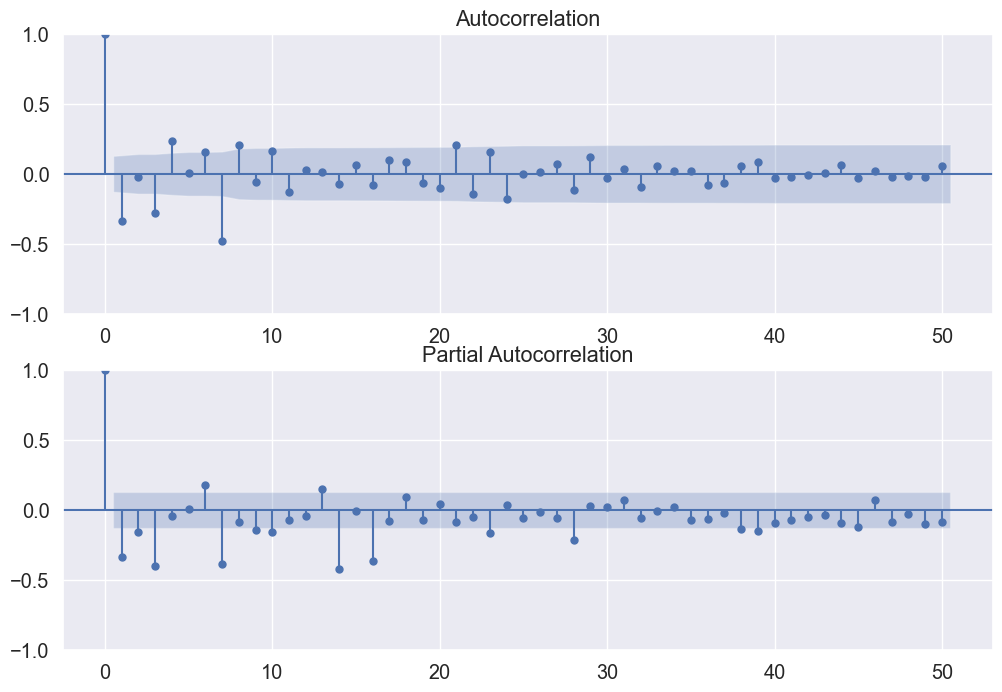

In [21]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(orders_sum_all_area_day_sum_sdif, lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(orders_sum_all_area_day_sum_sdif, lags=50, ax=ax2)
plt.show()

По графикам видно несколько значимых лагов в начале, а так же значимые лаги через периоды сезонности.

Разберем график автокорреляций. По графику видим, что значимыми являются лаги 1,3 и 4, 6. Это означает, что в качестве начального значения для $q$ можно взять равной 6 или же 4 (т.к. 6-ая близка к незначимой).

Разберем график частичных автокорреляций. По определению частичная автокорреляция это корреляция значения ряда после снятия с него линейной зависимости от предыдущих значений ряда. Это величина корреляции между переменной и переменной с некоторым лагом, которая "не объясняется" корреляциями переменных с меньшим лагом. Поэтому в качестве начальных значений $p$ можно взять 6 или же 3 (т.к. 6-ая близка к незначимой).

Отдельно посмотрим на 7-й лаг, который соответствует периоду сезонности.
В модели SARIMA значение в момент времени $t-7$ учитывается с некоторым коэффициентом, который мы включим в модель с помощью сезонной компоненты. Значения 7, 14 и т.д. лагов могут помочь при выборе начального значения для $P$, по сезонным лагам можно также подобрать начальное значение для $Q$. Также для выбора этого значения стоит смотреть на коррелограмму ряда до сезонного дифференцирования.

#### Выбор модели

Сделаем полный перебор по сетке вокруг начальных значений параметров. Зададим сетку:

In [29]:
p = range(1, 7)
q = range(3, 7)
d = [1]
P = range(0, 7)
D = [1]
Q = range(0, 7)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7)
                for x in list(itertools.product(P, D, Q))]

Класс, реализующий модель SARIMAX$(p, d, q) \times (P, D, Q)_s$

`class` <a href="http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html">`statsmodels.tsa.statespace.sarimax.SARIMAX`</a>`(endog, exog=None, order=(1, 0, 0), seasonal_order=(0, 0, 0, 0), trend=None, measurement_error=False, time_varying_regression=False, mle_regression=True, simple_differencing=False, enforce_stationarity=True, enforce_invertibility=True, hamilton_representation=False, **kwargs)`

Параметры:

* `endog` &mdash; временной ряд;
* `exog` &mdash; экзогенные факторы (регрессоры);
* `order` = гиперпараметы $(p, d, q)$ модели ARIMA;
* `seasonal_order` = сезонные гиперпараметры $(P, D, Q, s)$
* `trend` &mdash; тренд по времени. Например, если `trend=[1,1,0,1]`, то модель содержит $a + bt + ct^3$. По умолчанию тренд не используется;
* `enforce_stationarity` &mdash; требовать ли стационарность AR компоненты. Если нет, то AR-составляющая модели может задавать нестационарный ряд. Если да, то модель может не подобраться;
* `enforce_invertibility ` &mdash; требовать ли обратимость MA компоненты.

Атрибуты построенной модели:

* `polynomial_ar` &mdash; коэффициенты AR-составляющей;
* `polynomial_ma` &mdash; коэффициенты MA-составляющей;
* `polynomial_seasonal_ar` &mdash; коэффициенты сезонной AR-составляющей;
* `polynomial_seasonal_ma` &mdash; коэффициенты сезонной MA-составляющей;
* `polynomial_trend` &mdash; коэффициенты тренда по времени;
* и другие.

Информационный критерий Акаике (AIC) — критерий, применяющийся исключительно для выбора из нескольких статистических моделей.

При сравнении двух моделей, у которой AIC ниже, обычно "лучше".
Применим этот критерий для сравнения различных моделей SARIMA.

In [ ]:
best_aic = np.inf
best_params = None

for param in tqdm_notebook(pdq):
    for param_seasonal in tqdm_notebook(seasonal_pdq, leave=False):
        try:
            model = sm.tsa.statespace.SARIMAX(
                train, order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False, with_intercept=False)
            model = model.fit()
            print(f'SARIMA{param}x{param_seasonal} has AIC: {model.aic}')

            if model.aic < best_aic:
                best_aic = model.aic
                best_params = param, param_seasonal
            print('current best model - SARIMA{}x{}'.format(best_params[0], best_params[1]))
            print(f'with AIC: {best_aic}')

        except:
            # Обработка ошибок при построении модели
            continue

Оптимальной является модель

In [60]:
print('SARIMA{}x{}'.format(best_params[0], best_params[1]))
print(f'with AIC: {best_aic}')

SARIMA(2, 1, 3)x(2, 1, 0, 7)
with AIC: 34.0


#### Анализ статистических свойств модели

Обучим эту модель и выведем некоторые статистические свойства

In [113]:
model = sm.tsa.statespace.SARIMAX(
    train, order=(2, 1, 3), seasonal_order=(2, 1, 0, 7), enforce_stationarity=False, enforce_invertibility=False,
    with_intercept=False)

model = model.fit()
print(model.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2981      0.176     -1.697      0.090      -0.642       0.046
ar.L2         -0.7300      0.134     -5.433      0.000      -0.993      -0.467
ma.L1         -0.2470      0.166     -1.488      0.137      -0.572       0.078
ma.L2          0.4306      0.154      2.791      0.005       0.128       0.733
ma.L3         -0.5939      0.092     -6.486      0.000      -0.773      -0.414
ar.S.L7       -0.6228      0.105     -5.927      0.000      -0.829      -0.417
ar.S.L14      -0.4327      0.104     -4.158      0.000      -0.637      -0.229
sigma2      6.529e+05   3.97e+04     16.436      0.000    5.75e+05    7.31e+05


*Описание таблицы*:

* В первом столбце выписаны названия коэффициентов. Например, `ar.L2` &mdash; название коэффициента перед второй авторегрессионной компонентой, то есть перед $y_{t-2}$; а `ma.S.L7` &mdash; название коэффициента перед первой сезонной компонентой модели скользящего среднего, то есть перед $\varepsilon_{t-7}$.

* Второй и третий столбцы (`coef` и `std err`) &mdash; оценки коэффициента и стандартного отклонения.

* Четвертый и пятый столбцы отвечают проверке гипотезы о значимости коэффициента ($\mathsf{H}_0\colon$ коэффициент равен 0 $vs. \mathsf{H}_1\colon$ коэффициент не равен 0; см. линейные гипотезы в гауссовской модели). Столбец `z` &mdash; значение статистики критерия, столбец `P>|z|` &mdash; p-value критерия.

* Последние два столбца отвечают за 95%-доверительный интервал. Можно заметить, что доверительный интервал содержит 0 только для незначимых коэффициентов.

Полная таблица статистических свойств модели

In [114]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         orders_cnt   No. Observations:                  214
Model:             SARIMAX(2, 1, 3)x(2, 1, [], 7)   Log Likelihood               -1541.798
Date:                            Thu, 06 Oct 2022   AIC                           3099.596
Time:                                    22:33:50   BIC                           3125.572
Sample:                                04-01-2021   HQIC                          3110.119
                                     - 10-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2981      0.176     -1.697      0.090      -0.642       0.046
ar.L2         -0.7300      0.134     -5.433      0.000      -0.993      -0.467
ma.L1         -0.2470      0.166     -1.488      0.137      -0.572       0.078
ma.L2          0.4306      0.154      2.791      0.005       0.128       0.733
ma.L3         -0.5939      0.092     -6.486      0.000      -0.773      -0.414
ar.S.L7       -0.6228      0.105     -5.927      0.000      -0.829      -0.417
ar.S.L14      -0.4327      0.104     -4.158      0.000      -0.637      -0.229
sigma2      6.529e+05   3.97e+04     16.436      0.000    5.75e+05    7.31e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):               886.79
Prob(Q):                              0.49   Prob(JB):                         0.00
Heteroskedasticity (H):               4.40   Skew:                            -0.31
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

В последней таблице приведены значения статистик и pvalue для критериев Льюнга-Бокса (автокоррелированность), проверки на гомоскедастичность и критерий Жарка-Бера (нормальность). Кроме того, приведены значения коэффициентов ассиметрии и эксцесса.

--------------------

Метод `plot_diagnostics` позволяет быстро сделать диагностику модели и исследовать любое необычное поведение.

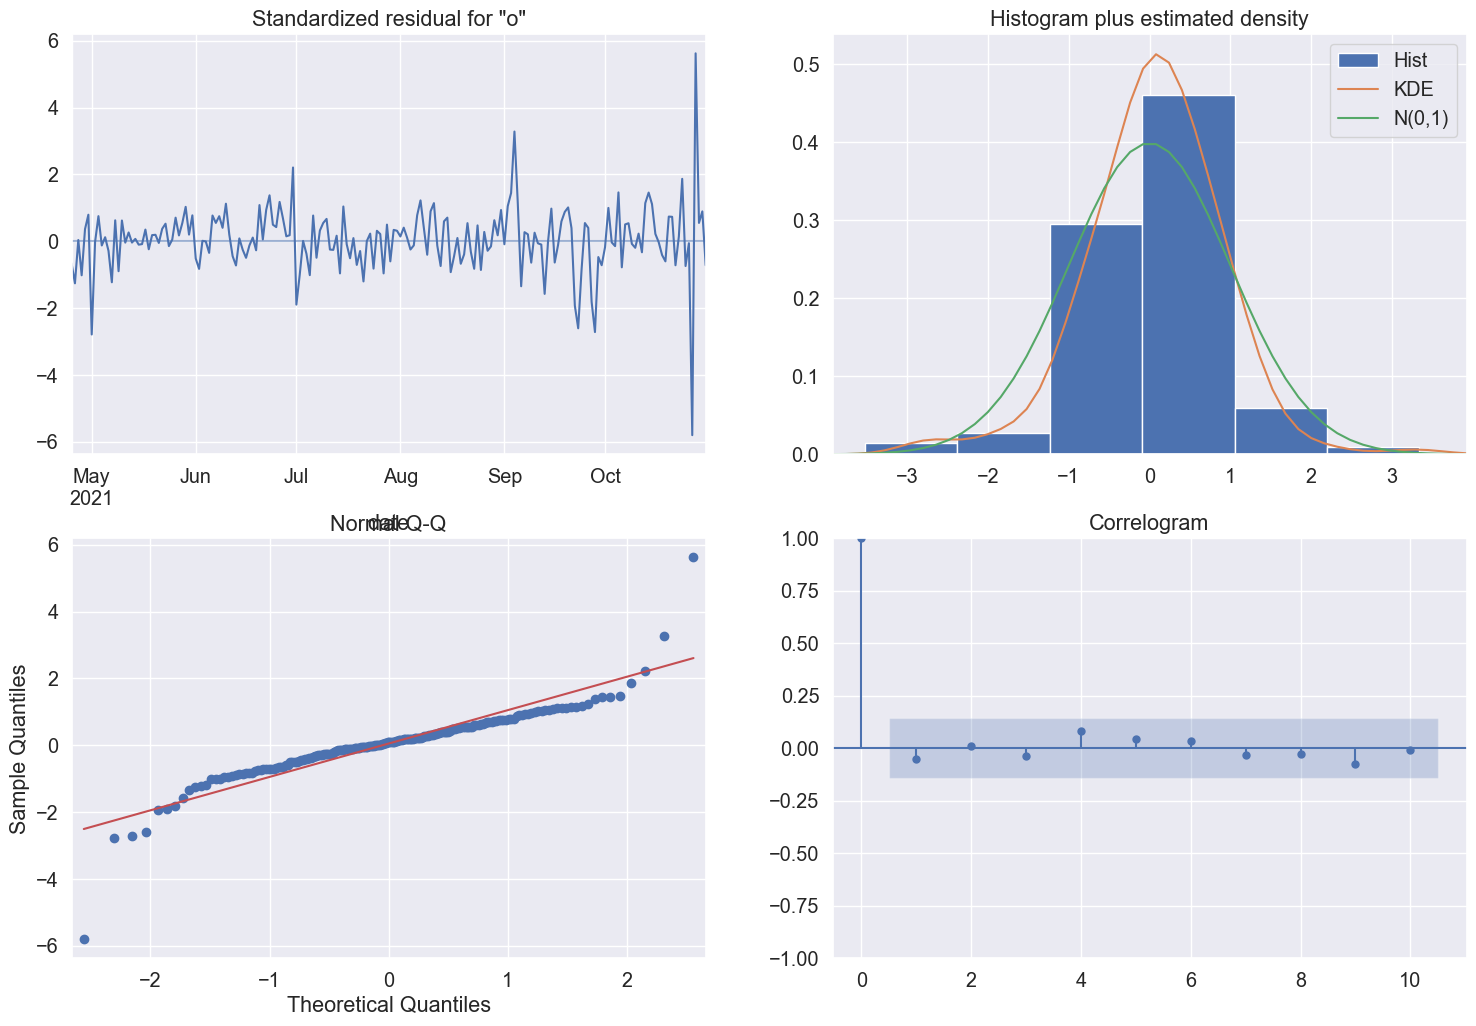

In [115]:
model.plot_diagnostics(figsize=(18, 12))
plt.show()

Первый график &mdash; график остатков модели.
На следующем графике (верхний правый) изображена гистограмма для остатков, ядерная оценка плостности и плотность стандартного нормального распределения.
Третий график Q-Q plot служит для визуальной проверки нормальности.

По графикам видно, остатки некоррелированы и остатки имеют нулевое среднее значение(близкое к нулевому значению). В целом можно сказать что остатки распределяются нормально.

#### Посмотрим как прогнозирует модель

Сделаем прогноз на месяц вперед

In [116]:
spred = model.get_prediction(start=pd.to_datetime('2021-11-01'), end=pd.to_datetime('2022-01-01'),
                             dynamic=False, full_results=True)
spred_mean = spred.predicted_mean
spred_ci = spred.conf_int()

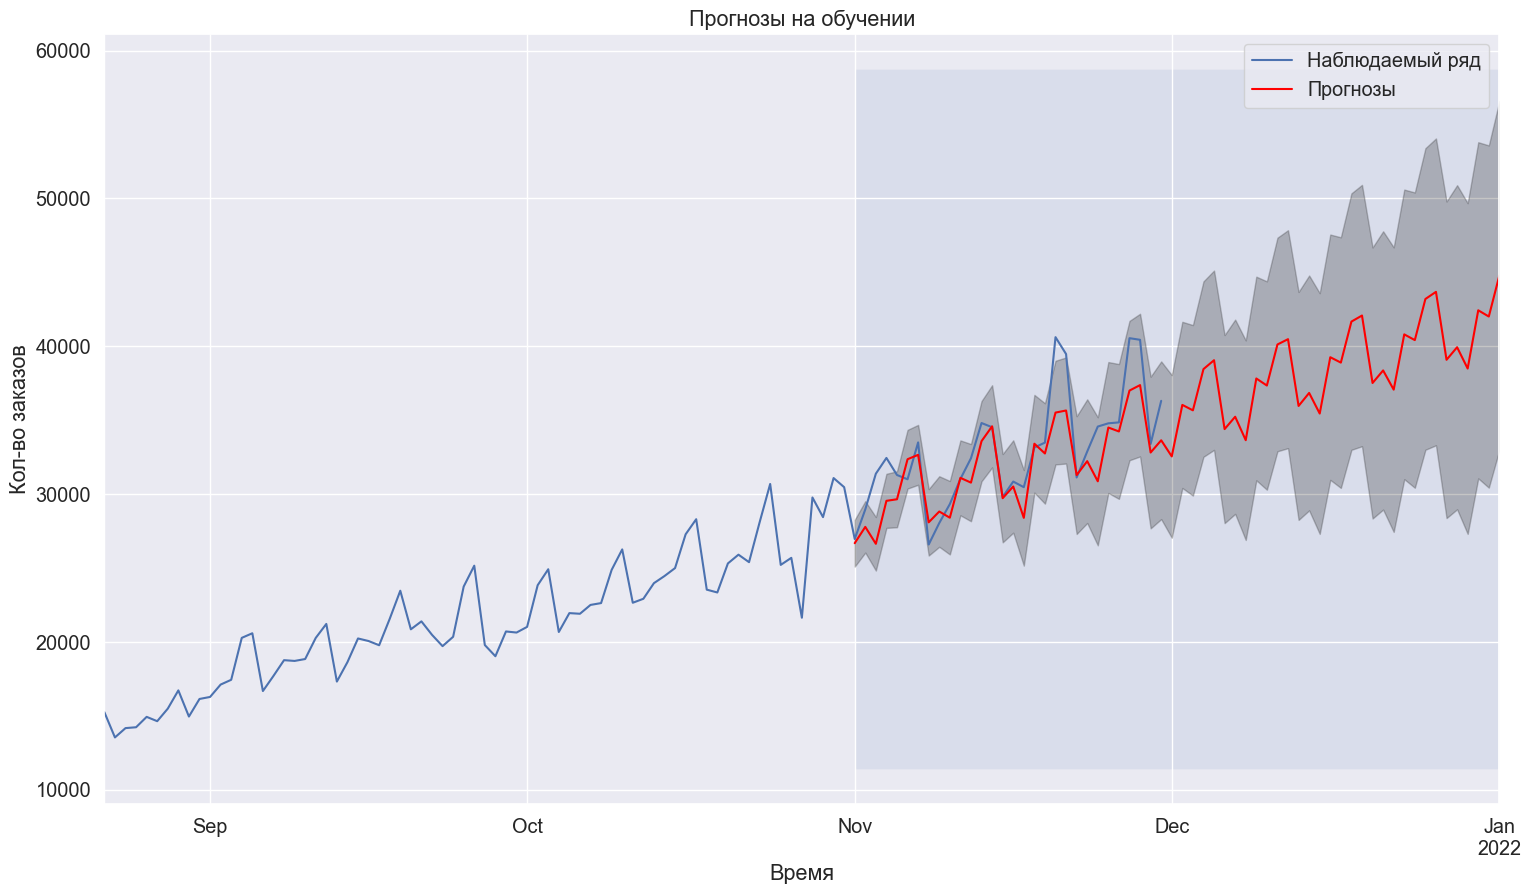

In [117]:
# временной ряд
ax = orders_sum_all_area_day_sum['2021-08-22':].plot(label='Наблюдаемый ряд', figsize=(18, 10))

# прогнозы
spred_mean.plot(label='Прогнозы', ax=ax, color='red')
# предсказательный интервал
ax.fill_between(spred_ci.index, spred_ci.iloc[:, 0],
                spred_ci.iloc[:, 1],
                color='k', alpha=.25)

# область прогнозирования
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2021-11-01'),
                 pd.to_datetime('2022-01-01'), alpha=.1, zorder=-1)

ax.set_xlabel('Время')
ax.set_ylabel('Кол-во заказов')
plt.title('Прогнозы на обучении')
plt.legend()
plt.show()

In [118]:
orders_sum_all_area_day_sum_truth = orders_sum_all_area_day_sum['2021-11-01':]
rmse = np.sqrt(((spred_mean - orders_sum_all_area_day_sum_truth) ** 2).mean())
print('RMSE = {:.3f}'.format(rmse))

RMSE = 2123.572


Посмотрим на динамические прогнозы

In [119]:
spred_dynamic = model.get_prediction(start=pd.to_datetime('2021-11-01'), end=pd.to_datetime('2022-01-01'),
                                    dynamic=True, full_results=True)
spred_dynamic_mean = spred_dynamic.predicted_mean
spred_dynamic_ci = spred_dynamic.conf_int()

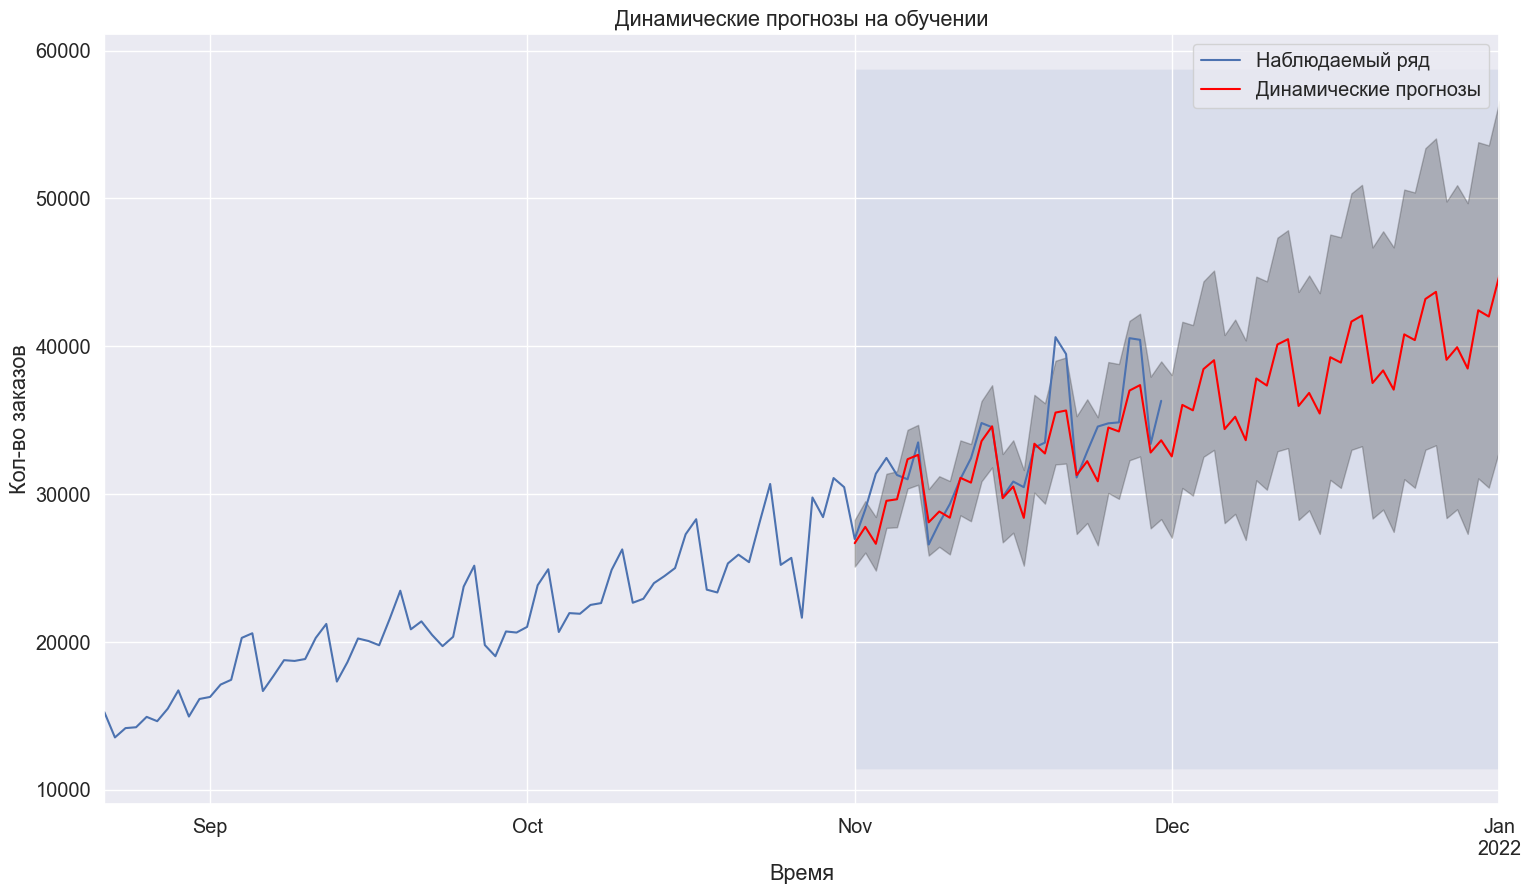

In [120]:
# временной ряд
ax = orders_sum_all_area_day_sum['2021-08-22':].plot(label='Наблюдаемый ряд', figsize=(18, 10))

# прогнозы
spred_dynamic_mean.plot(label='Динамические прогнозы', ax=ax, color='red')
# предсказательный интервал
ax.fill_between(spred_dynamic_ci.index, spred_dynamic_ci.iloc[:, 0],
                spred_dynamic_ci.iloc[:, 1],
                color='k', alpha=.25)

# область прогнозирования
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2021-11-01'),
                 pd.to_datetime('2022-01-01'), alpha=.1, zorder=-1)

ax.set_xlabel('Время')
ax.set_ylabel('Кол-во заказов')
plt.title('Динамические прогнозы на обучении')
plt.legend()
plt.show()

In [121]:
orders_sum_all_area_day_sum_truth = orders_sum_all_area_day_sum['2021-11-01':]
rmse = np.sqrt(((spred_dynamic_mean - orders_sum_all_area_day_sum_truth) ** 2).mean())
print('RMSE = {:.3f}'.format(rmse))

RMSE = 2123.572


#### Auto Arima

Класс, реализующий модель Auto Arima$(p, d, q) \times (P, D, Q)_s$, а именно &mdash; перебор параметров.

`class` <a href="https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html?highlight=auto_arima#pmdarima.arima.auto_arima">`pmdarima.arima.auto_arima`</a>`(y, X=None, start_p=2, d=None, max_p=6, start_q=1, max_q=6, max_d=2, start_P=1, max_P=6, max_D=1, start_Q=1, max_Q=6, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)`

Параметры:

* `y` &mdash; временной ряд;
* `X` &mdash; экзогенные факторы (регрессоры);
* `start_p=1, max_p=6, start_q=1, max_q=6, max_d=2, start_P=1, max_P=6, max_D=1, start_Q=1, max_Q=6 ` &mdash; гиперпараметы для перебора;
* `m` &mdash; сезонность;
* `maxiter` &mdash; максимальное количество оценок функций.

In [66]:
pm.auto_arima(train, seasonal=True, m=7,
              trace=True, suppress_warnings=True, error_actions='ignore',
              enforce_stationarity=False, enforce_invertibility=False, with_intercept=False)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7]             : AIC=inf, Time=1.26 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=3684.782, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[7]             : AIC=3563.946, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[7]             : AIC=3588.680, Time=0.14 sec
 ARIMA(1,1,0)(0,0,0)[7]             : AIC=3673.487, Time=0.01 sec
 ARIMA(1,1,0)(2,0,0)[7]             : AIC=3546.634, Time=0.18 sec
 ARIMA(1,1,0)(2,0,1)[7]             : AIC=3531.647, Time=0.55 sec
 ARIMA(1,1,0)(1,0,1)[7]             : AIC=3531.364, Time=0.32 sec
 ARIMA(1,1,0)(0,0,1)[7]             : AIC=3606.863, Time=0.11 sec
 ARIMA(1,1,0)(1,0,2)[7]             : AIC=3528.897, Time=0.43 sec
 ARIMA(1,1,0)(0,0,2)[7]             : AIC=3598.489, Time=0.21 sec
 ARIMA(1,1,0)(2,0,2)[7]             : AIC=3534.645, Time=0.51 sec
 ARIMA(0,1,0)(1,0,2)[7]             : AIC=3556.220, Time=0.26 sec
 ARIMA(2,1,0)(1,0,2)[7]             : AIC=3522.342, Time=0.38 sec
 ARIMA(2,1,0)(0,0,2)[7]             : 

ARIMA(order=(3, 1, 1), scoring_args={}, seasonal_order=(1, 0, 2, 7),
      suppress_warnings=True, with_intercept=False)

Лучшей моделью оказалась `ARIMA(1,1,1)(1,0,1)[7]`.

Подставим параметры в модель SARIMAX.

In [56]:
auto_model = sm.tsa.statespace.SARIMAX(
    train, order=(3, 0, 1), seasonal_order=(1, 0, 2, 7), enforce_stationarity=False, enforce_invertibility=False,
    with_intercept=False)

auto_model = auto_model.fit()

C:\Users\Tim\PycharmProjects\FINAL_SARIMAX_AAAAAAA\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [57]:
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                             orders_cnt   No. Observations:                  214
Model:             SARIMAX(3, 0, 1)x(1, 0, [1, 2], 7)   Log Likelihood               -1618.706
Date:                                Fri, 07 Oct 2022   AIC                           3253.412
Time:                                        19:49:14   BIC                           3279.718
Sample:                                    04-01-2021   HQIC                          3264.059
                                         - 10-31-2021                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9343      0.164      5.698      0.000       0.613       1.256
ar.L2          0.0357      0.093      0.384      0.701      -0.146       0.218
ar.L3          0.0099      0.118      0.084      0.933      -0.220       0.240
ma.L1         -0.6645      0.158     -4.212      0.000      -0.974      -0.355
ar.S.L7        1.0629      0.015     72.018      0.000       1.034       1.092
ma.S.L7       -0.8989      0.133     -6.733      0.000      -1.160      -0.637
ma.S.L14       0.1867      0.104      1.803      0.071      -0.016       0.390
sigma2      7.742e+05   4.45e+04     17.413      0.000    6.87e+05    8.61e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.22   Jarque-Bera (JB):               714.38
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               3.55   Skew:                            -0.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Сделаем диагностику авто модели

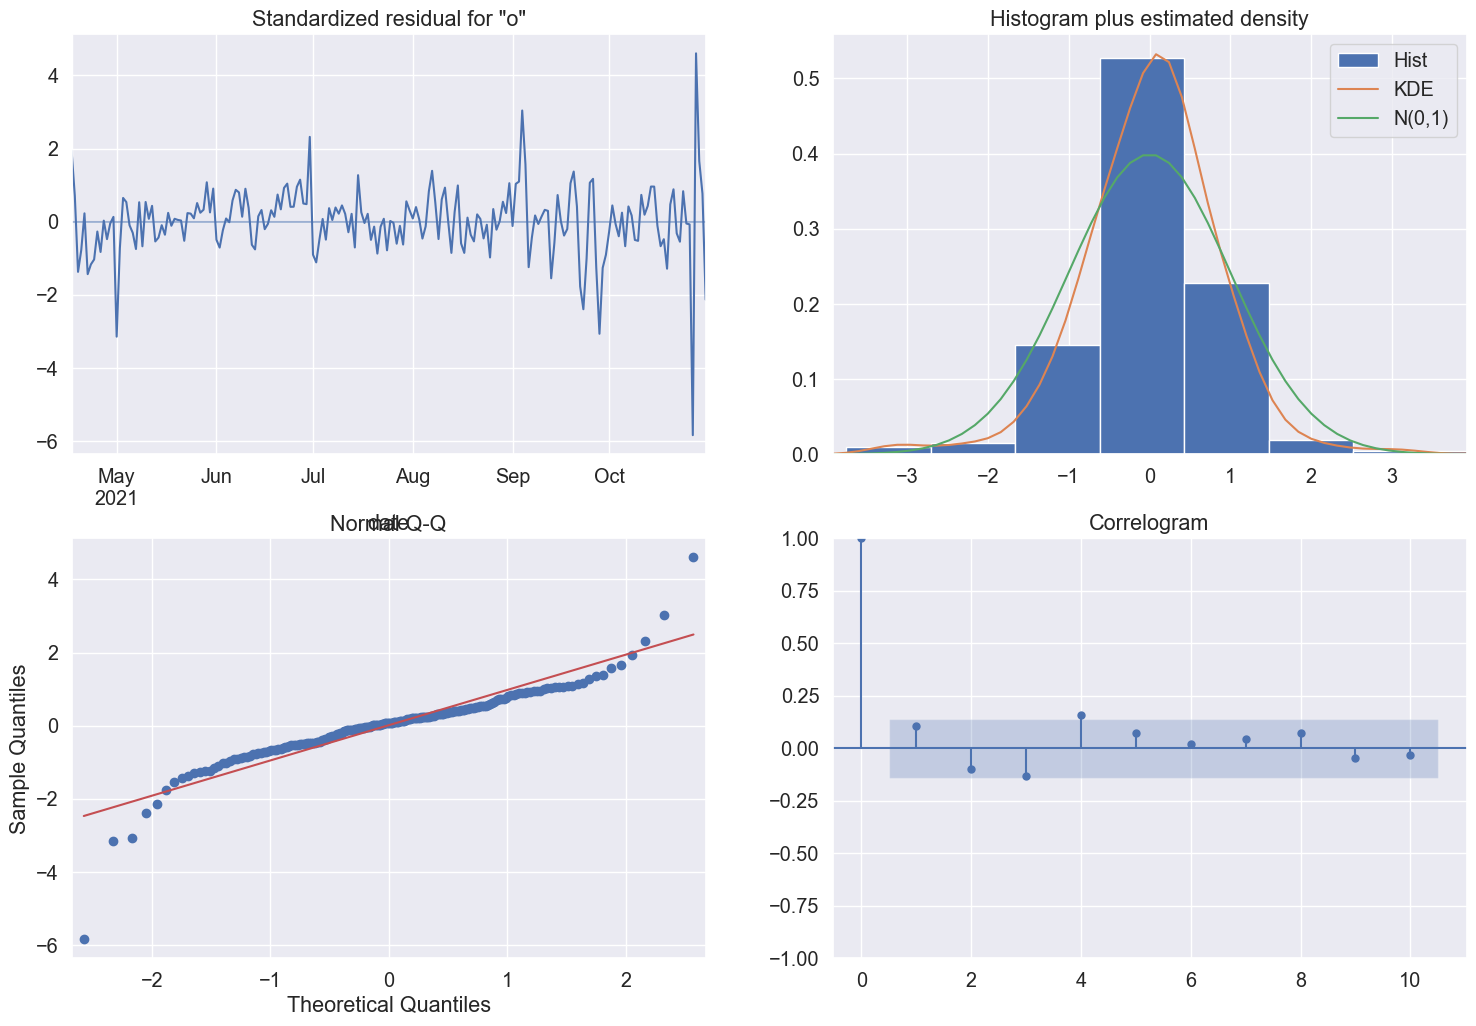

In [58]:
auto_model.plot_diagnostics(figsize=(18, 12))
plt.show()

Посмотрим, как прогнозирует модель:

In [59]:
pred = auto_model.get_prediction(start=pd.to_datetime('2021-11-01'), end=pd.to_datetime('2022-01-01'), dynamic=False, full_results=True)
pred_mean = pred.predicted_mean
pred_ci = pred.conf_int()

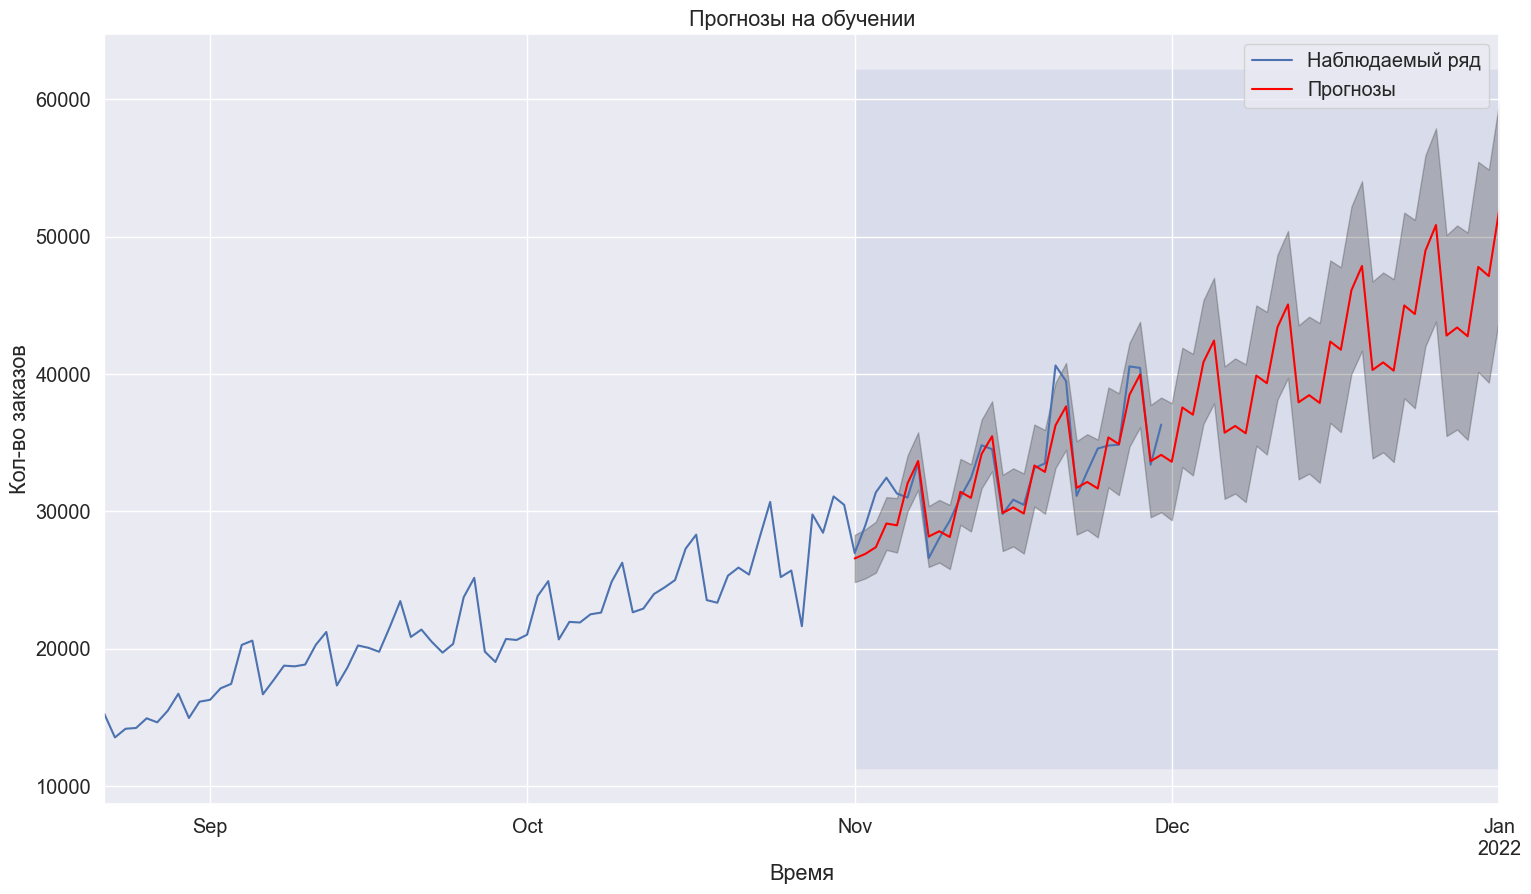

In [60]:
# временной ряд
ax = orders_sum_all_area_day_sum['2021-08-22':].plot(label='Наблюдаемый ряд', figsize=(18, 10))

# прогнозы
pred_mean.plot(label='Прогнозы', ax=ax, color='red')
# предсказательный интервал
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1],
                color='k', alpha=.25)

# область прогнозирования
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2021-11-01'),
                 pd.to_datetime('2022-01-01'), alpha=.1, zorder=-1)

ax.set_xlabel('Время')
ax.set_ylabel('Кол-во заказов')
plt.title('Прогнозы на обучении')
plt.legend()
plt.show()

In [61]:
orders_sum_all_area_day_sum_truth = orders_sum_all_area_day_sum['2021-11-01':]
rmse = np.sqrt(((pred_mean - orders_sum_all_area_day_sum_truth) ** 2).mean())
print('RMSE = {:.3f}'.format(rmse))

RMSE = 1714.634


In [62]:
pred_dynamic = auto_model.get_prediction(start=pd.to_datetime('2021-11-01'), end=pd.to_datetime('2022-01-01'), dynamic=True, full_results=True)
pred_mean = pred_dynamic.predicted_mean
pred_dynamic_ci = pred_dynamic.conf_int()

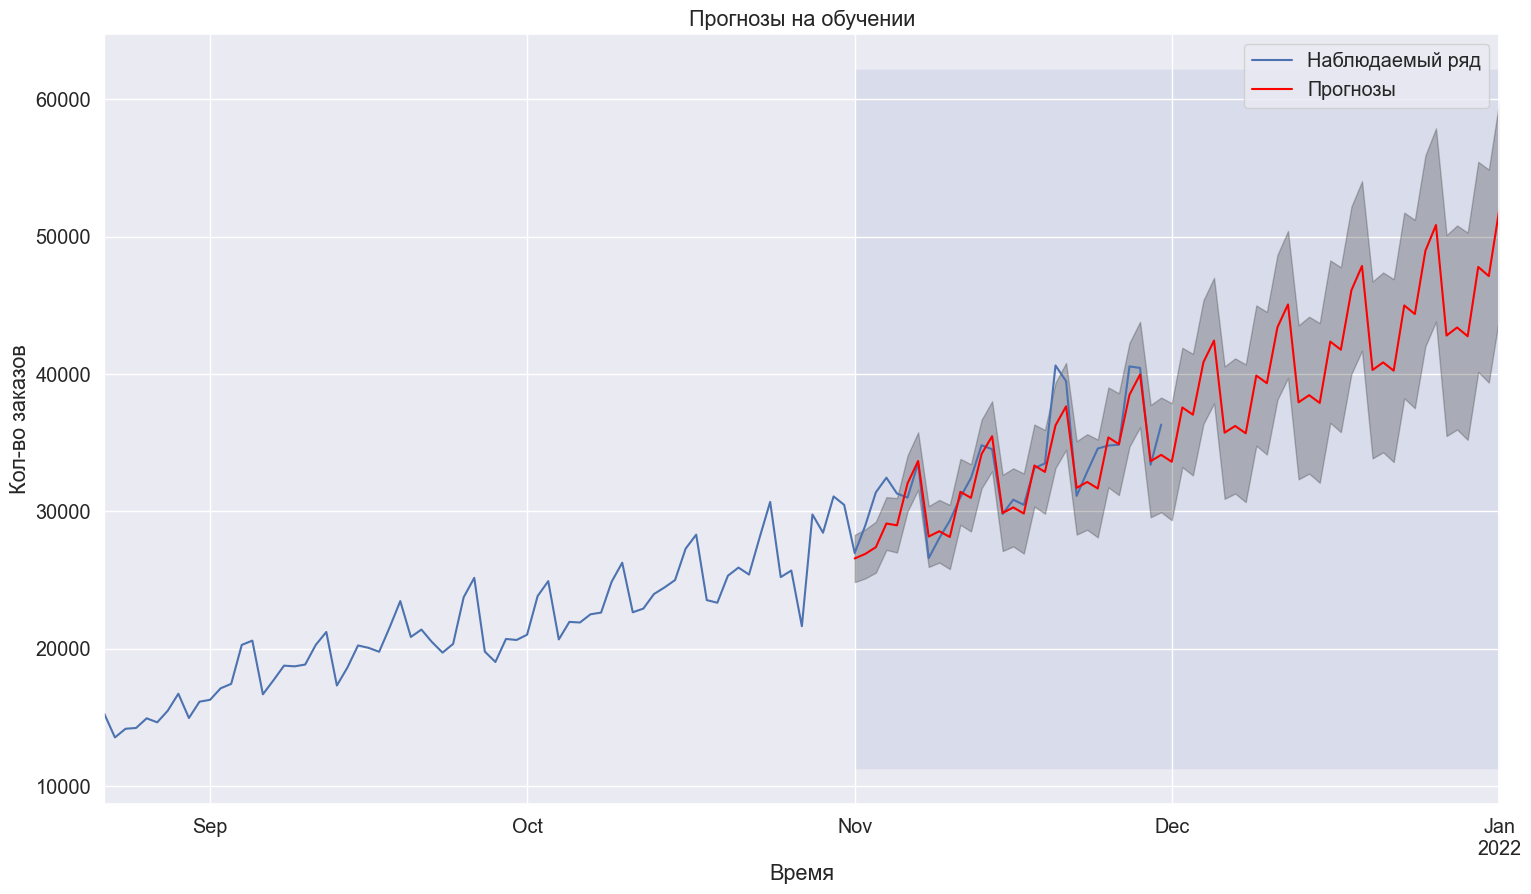

In [63]:
# временной ряд
ax = orders_sum_all_area_day_sum['2021-08-22':].plot(label='Наблюдаемый ряд', figsize=(18, 10))

# прогнозы
pred_mean.plot(label='Прогнозы', ax=ax, color='red')
# предсказательный интервал
ax.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:, 0], pred_dynamic_ci.iloc[:, 1],
                color='k', alpha=.25)

# область прогнозирования
ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2021-11-01'),
                 pd.to_datetime('2022-01-01'), alpha=.1, zorder=-1)

ax.set_xlabel('Время')
ax.set_ylabel('Кол-во заказов')
plt.title('Прогнозы на обучении')
plt.legend()
plt.show()

In [64]:
orders_sum_all_area_day_sum_truth = orders_sum_all_area_day_sum['2021-11-01':]
rmse = np.sqrt(((pred_mean - orders_sum_all_area_day_sum_truth) ** 2).mean())
print('RMSE = {:.3f}'.format(rmse))

RMSE = 1714.634


In [65]:
from sklearn.metrics import mean_absolute_percentage_error
mape = mean_absolute_percentage_error(pred_mean[:len(orders_sum_all_area_day_sum_truth)], orders_sum_all_area_day_sum_truth)
print(f'mape = {mape}')

mape = 0.04044848937515179
